In [1]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

# Gate compilation given its columns via Householder reflections

In [2]:
import random

from scipy.stats import unitary_group
import numpy as np

from qualtran import BloqBuilder
from qualtran.bloqs.basic_gates import PlusState
from qualtran.drawing import show_bloq
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientState
from qualtran.bloqs.chemistry.prepare_mps.compile_gate import CompileGateFromColumns

This bloq compiles a quantum gate $U$ given a list of its columns, which might be incomplete. It uses Householder reflections on states prepared with `StatePreparationViaRotations`.

Refer to https://arxiv.org/abs/1306.3200 for the method used.

## Example of use

Assume one wants to compile a `gate_bitsize` qubit gate $U$ using a rotation precision given by `phase_bitsize`.

In [3]:
def getRandomUnitary (gate_bitsize):
  U = unitary_group.rvs(2**gate_bitsize)
  return U

gate_bitsize = 2
phase_bitsize = 3
U = getRandomUnitary(gate_bitsize)

## Building the Bloq

The parameters the bloq receives are:

  - `phase_bitsize`: number of qubits used to store the rotation angle. This determines the
    accuracy of the results, but increases computational resources.
  - `gate_cols`: tuple that contains the columns of the gate. In each position this tuple has to
    contain the index of the column and the data that it stores, i.e.: ((0, (1j,0)), (1, (0,1))).
  - `uncompute`: defaults to `False`. Wether the compiled gate is $U$ or $U^\dagger$. If true, the
    data in `gate_cols`: determines the rows of the matrix, and the vectors will be transposed. That
    is, if one wants to implement $U^\dagger$ the `gate_cols` provided must be the same as in the
    case of $U$. This can also be used if one wants to specify the rows of $U$ instead of the
    columns. In this case take the conjugate of the coefficients.
  - `internal_phase_grad`: if True, an internal phase gradient is used. Otherwise the user must
    provide one when calling the bloq. It adds the cost of generating this state to the overall cost
    of the Bloq, thus it should be set to True only when a single gate is to be produced or if Tcost
    is irrelevant. Defaults to False.
  - `internal_refl_ancilla`: if True, an internal register is used for the reflection ancilla,
    otherwise it must be provided when calling the bloq. This register indicates the probability of
    failure when producing the unitary (more on this in the section _Unitarity and error probability_
    ), so it can be used externally for benchmarking. Defaults to True.

The data in the array `U` declared previously must be adapted to the correct format. Below is an
example of use together with its bloq decomposition for a gate that requires both the reflection
ancilla and a phase gradient.

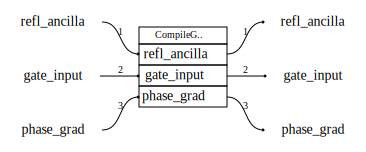

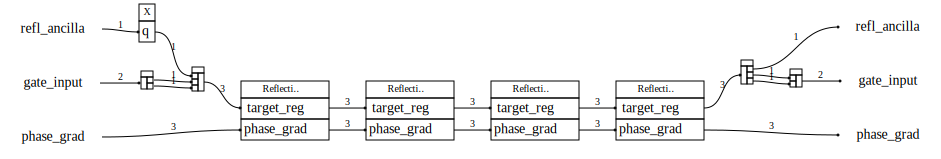

In [4]:
# remember to take the transpose of the gate, as the vectors specify the columns of the matrix
gate_cols = tuple([(i, tuple(c)) for i,c in enumerate(U.T)])
gate_compiler = CompileGateFromColumns(phase_bitsize=phase_bitsize, gate_cols=gate_cols, internal_refl_ancilla=False)

show_bloq(gate_compiler)
show_bloq(gate_compiler.decompose_bloq())

For each column it is possible to see a reflection bloq.

## Using the bloq in a circuit

Now let us show an example of how to use this bloq in a circuit, together with the tensor
contraction of it to show that it correctly implements the desired gate.

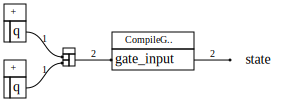

In [5]:
gate_compiler = CompileGateFromColumns(phase_bitsize, gate_cols, internal_phase_grad=True)

bb = BloqBuilder()
state = bb.join(np.array([bb.add(PlusState()), bb.add(PlusState())]))
state = bb.add(gate_compiler, gate_input = state)
circuit = bb.finalize(state=state)

show_bloq(circuit)
result = circuit.tensor_contract()
compiled_gate = gate_compiler.tensor_contract()

And finally a comparison with the correct results.

In [6]:
def c2pol (c):
    # round 0 to eliminate phase
    if abs(c) < 1e-14:
        c = 0
    return f"{abs(c):.3f} ∠ {np.angle(c, deg=True):06.2f}º"

def compare_gate_results (comp, original):
    print("* compiled gate  ||  original gate U (coefficients in polar form):\n")
    for compiled, correct in zip(comp, original):
        print("  ".join([c2pol(c) for c in compiled]) + "    ||    "\
            + "  ".join([c2pol(c) for c in correct]))

correct_result = 0.5*U@np.ones((4,1))
correct_result = correct_result.reshape((-1))

accuracy = abs(np.dot(correct_result.conj(), result))
print(f"* Accuracy of <++|U U_compiled|++>: {accuracy}\n")

print("* Comparison of U|++> (coefficients in polar form):\n")
for i, (compiled, correct) in enumerate(zip(result, correct_result)):
    print(f"  |{i:0{gate_bitsize}b}> result: {c2pol(compiled)}     correct: {c2pol(correct)}")

print("\n")
compare_gate_results(compiled_gate, U)

* Accuracy of <++|U U_compiled|++>: 0.9222371264957518

* Comparison of U|++> (coefficients in polar form):

  |00> result: 0.187 ∠ 034.34º     correct: 0.312 ∠ 021.58º
  |01> result: 0.062 ∠ -82.88º     correct: 0.084 ∠ -19.79º
  |10> result: 0.833 ∠ -143.92º     correct: 0.813 ∠ -154.97º
  |11> result: 0.459 ∠ -09.08º     correct: 0.484 ∠ 017.98º


* compiled gate  ||  original gate U (coefficients in polar form):

0.622 ∠ -126.98º  0.321 ∠ -01.25º  0.663 ∠ 067.15º  0.146 ∠ 045.00º    ||    0.617 ∠ -93.91º  0.224 ∠ -01.10º  0.716 ∠ 070.82º  0.239 ∠ 046.65º
0.351 ∠ -112.51º  0.562 ∠ 072.63º  0.629 ∠ -68.40º  0.354 ∠ 135.00º    ||    0.390 ∠ -93.58º  0.615 ∠ 060.00º  0.542 ∠ -74.34º  0.420 ∠ 130.21º
0.616 ∠ -141.73º  0.514 ∠ -171.80º  0.393 ∠ -154.01º  0.354 ∠ -90.00º    ||    0.668 ∠ -137.57º  0.454 ∠ 159.46º  0.441 ∠ -177.05º  0.391 ∠ -107.02º
0.081 ∠ 042.75º  0.490 ∠ 066.12º  0.062 ∠ -45.00º  0.854 ∠ -45.00º    ||    0.145 ∠ 055.72º  0.604 ∠ 072.98º  0.010 ∠ 167.25º  0.783 ∠ -30.76º

## Unitarity and error probability

This bloq works by implementing each column separately with a reflection. These reflections rely
on the columns of the original gate being unitary. This is the case for all quantum operators.
Unfortunately, the columns that end up being produced are approximations to the original ones and
are not guaranteed to be orthogonal (even though the projection decreases exponentially with
the value of `phase_bitsize`). Because of this reason, the output of this gate ends up entangled
with the reflection ancilla. When the reflection ancilla is projected into $|0\rangle$ (either
internally or externally by the user), this results in a state that is not normalized. In a real
quantum circuit, measuring the reflection ancilla would reveal wether the application of the gate
was successful or not.

As mentioned before, this error decreases exponentially with `phase bitsize`, which does not
contribute greatly to the T-gate count of the algorithm, so if sufficient computational resources
are available, such as ancilla qubits and computing power for contracting the circuit, it is a good
idea to keep this value as high as possible.

Before preceding to review the failure probability and the error, let us recall that the gate
decomposition of an unitary $U$ is done though a reflection ancilla that acts as
$V = |0\rangle\langle 1| U + |1\rangle\langle 0| U^\dagger$ (even though internally the bloq applies
an $X$ gate to the reflection ancilla to transform it to
$V = |0\rangle\langle 0| U + |1\rangle\langle 1| U^\dagger$). If the decomposition is ideal then the
bloq acts as $V|0_\text{refl},0> = |0_\text{refl}\rangle U|0\rangle$, but because of the
non-orthogonality it results in
$V|0_\text{refl},0> = |1_\text{refl}\rangle|\text{trash}\rangle + |0_\text{refl}\rangle U|0\rangle$.
Thus, if the reflection ancilla is measured to be in the $|0\rangle$ state then the gate turned out
to be successfully decomposed, but otherwise the result is the entangled trash. Equivalently,
projecting the output on $|0\rangle$ and taking the square of the modulus gives the probability of
success, as will be shown later.

Let us show now an example of a gate that can be exactly decomposed, together with its $V$
representation.

In [7]:
phase_bitsize = 2
non_approximable_cols = ((0, ((0.5+0.5j), (0.5-0.5j))),
                         (1, ((-0.5-0.5j), (0.5-0.5j))))

perfectly_decomposed_gate = CompileGateFromColumns(phase_bitsize, non_approximable_cols, internal_phase_grad=True, internal_refl_ancilla=False)

print(f" * Original matrix U (coefficients in polar form):")
for row in np.array([col[1] for col in non_approximable_cols]).T:
    print("  ".join([c2pol(c) for c in row]))

print(f"\n * Resulting matrix V (coefficients in polar form):")
for row in perfectly_decomposed_gate.tensor_contract():
    print("  ".join([c2pol(c) for c in row]))

 * Original matrix U (coefficients in polar form):
0.707 ∠ 045.00º  0.707 ∠ -135.00º
0.707 ∠ -45.00º  0.707 ∠ -45.00º

 * Resulting matrix V (coefficients in polar form):
0.707 ∠ 045.00º  0.707 ∠ -135.00º  0.000 ∠ 000.00º  0.000 ∠ 000.00º
0.707 ∠ -45.00º  0.707 ∠ -45.00º  0.000 ∠ 000.00º  0.000 ∠ 000.00º
0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.707 ∠ -45.00º  0.707 ∠ 045.00º
0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.707 ∠ 135.00º  0.707 ∠ 045.00º


Now another matrix that can't be exactly decomposed with the `phase_bitsize` provided and thus
produces entanglement with the ancilla. This is indicated by the presence of non-zero entries
outside the upper left and lower right $2\times 2$ sectors.

In [8]:
phase_bitsize = 4
non_approximable_cols = ((0, ((-0.4561633949103061+0.663718460551421j), (0.21542649847315268-0.5522537333714933j))),
                         (1, ((0.5921919739627931-0.02648449057856236j), (0.7751214177490913-0.21861844725338886j))))


imperfectly_decomposed_gate = CompileGateFromColumns(phase_bitsize, non_approximable_cols, internal_phase_grad=True, internal_refl_ancilla=False)


print(f" * Original matrix U (coefficients in polar form):")
for row in np.array([col[1] for col in non_approximable_cols]).T:
    print("  ".join([c2pol(c) for c in row]))

V_coefs = imperfectly_decomposed_gate.tensor_contract()

print(f"\n * Resulting matrix V (coefficients in polar form):")
for row in V_coefs:
    print("  ".join([c2pol(c) for c in row]))

 * Original matrix U (coefficients in polar form):
0.805 ∠ 124.50º  0.593 ∠ -02.56º
0.593 ∠ -68.69º  0.805 ∠ -15.75º

 * Resulting matrix V (coefficients in polar form):
0.818 ∠ 116.85º  0.556 ∠ -11.25º  0.083 ∠ 078.75º  0.125 ∠ 101.25º
0.546 ∠ -63.15º  0.831 ∠ -11.25º  0.056 ∠ -101.25º  0.083 ∠ -78.75º
0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.831 ∠ -123.75º  0.556 ∠ 078.75º
0.180 ∠ -146.25º  0.000 ∠ 000.00º  0.546 ∠ -04.35º  0.818 ∠ 018.15º


Finally an estimate of the probability of failure when measuring the reflection ancilla (ignoring
second order terms). Which is computed as $1 - |\langle 0_\text{refl}|V|0_\text{refl},0\rangle |^2$.

In [9]:
p_failure = np.linalg.norm(V_coefs.T[0][2:])**2

bb = BloqBuilder()
state = bb.allocate(1)
refl_ancilla = bb.allocate()
refl_ancilla, state = bb.add(imperfectly_decomposed_gate, gate_input=state, refl_ancilla=refl_ancilla)
bb.free(refl_ancilla)
final_state = bb.finalize(state=state).tensor_contract()

p_failure = 1 - np.linalg.norm(final_state)**2
print(f"Probability of failure for V|0>: {p_failure*100:.4f}%")

Probability of failure for V|0>: 3.2486%


## Partial specification of the gate

As mentioned before, it is possible to specify only some columns of the matrix. However, take into
account that, if the input does not belong to the space spanned by the $k$ columns that were
specified, then there will be some degree of entanglement with the reflection ancilla. In the
extreme case in which the input state to the gate does not overlap with any column of the matrix at
all, the reflection ancilla will be at the state $|1\rangle$ when projected into $|0\rangle$
(at deallocation), thus leaving a null vector (not to be confused with the state $|0\rangle$).

Notice below that only the first and last columns are close to the original operator. Te rest are
set at zero because the non-zero values were present in the reflection ancilla $|1\rangle$ sector,
which was discarded when the reflection ancilla was deallocated.

In [10]:
partial_gate_cols = (gate_cols[0], gate_cols[-1])
gate_compiler = CompileGateFromColumns(phase_bitsize, partial_gate_cols, internal_phase_grad=True)
compiled = gate_compiler.tensor_contract()
compare_gate_results(compiled, U)

* compiled gate  ||  original gate U (coefficients in polar form):

0.564 ∠ -99.58º  0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.309 ∠ 045.00º    ||    0.617 ∠ -93.91º  0.224 ∠ -01.10º  0.716 ∠ 070.82º  0.239 ∠ 046.65º
0.370 ∠ -106.95º  0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.462 ∠ 135.00º    ||    0.390 ∠ -93.58º  0.615 ∠ 060.00º  0.542 ∠ -74.34º  0.420 ∠ 130.21º
0.715 ∠ -144.53º  0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.318 ∠ -101.25º    ||    0.668 ∠ -137.57º  0.454 ∠ 159.46º  0.441 ∠ -177.05º  0.391 ∠ -107.02º
0.156 ∠ 028.20º  0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.768 ∠ -33.75º    ||    0.145 ∠ 055.72º  0.604 ∠ 072.98º  0.010 ∠ 167.25º  0.783 ∠ -30.76º


## Using the adjoint

This bloq also implements the adjoint of the compiled gate though the attribute `uncompute`, which
is set to `False` as a default. In this example we will also provide a phase gradient externally to
illustrate how it works.

The circuit below prepares the identity by computing $U U^\dagger$ for a random unitary. Also,
because now two gate decomposition bloqs are being used, it is a good idea to provide a phase
gradient externally to improve T-gate count.

In [11]:
def gen_random_state (state_bitsizes: int):
    state = np.array([random.uniform(-1,1) + random.uniform(-1,1)*1j for _ in range(2**state_bitsizes)])
    return state/np.linalg.norm(state)

random_state = tuple(gen_random_state(gate_bitsize))
gate_comp     = CompileGateFromColumns(phase_bitsize, gate_cols, uncompute=False, internal_refl_ancilla=False)
gate_comp_adj = CompileGateFromColumns(phase_bitsize, gate_cols, uncompute=True, internal_refl_ancilla=False)

bb = BloqBuilder()
state = bb.add_register("gate_input", gate_bitsize)
pg = bb.add(PhaseGradientState(phase_bitsize))
ra = bb.allocate(1)
ra, state, pg = bb.add(gate_comp, gate_input=state, phase_grad=pg, refl_ancilla=ra)
ra, state, pg = bb.add(gate_comp_adj, gate_input=state, phase_grad=pg, refl_ancilla=ra)
bb.add(PhaseGradientState(phase_bitsize).adjoint(), phase_grad=pg)
bb.free(ra)
circuit = bb.finalize(gate_input=state)
result = circuit.tensor_contract()

print(f" * Resulting matrix (coefficients in polar form):")
for row in result:
    print("  ".join([c2pol(c) for c in row]))

 * Resulting matrix (coefficients in polar form):
1.000 ∠ 000.00º  0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.000 ∠ 000.00º
0.000 ∠ 000.00º  1.000 ∠ -00.00º  0.000 ∠ 000.00º  0.000 ∠ 000.00º
0.000 ∠ 000.00º  0.000 ∠ 000.00º  1.000 ∠ 000.00º  0.000 ∠ 000.00º
0.000 ∠ 000.00º  0.000 ∠ 000.00º  0.000 ∠ 000.00º  1.000 ∠ 000.00º


## Controlled version

# TODO